<h3>Import Required Packages & Data</h3>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import warnings
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from pathlib import Path

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# project path
from pathlib import Path
import pandas as pd
import warnings

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

CWD = Path.cwd()
print("CWD:", CWD)

# Try likely project roots (current, parent, grandparent)
CANDIDATES = [CWD, CWD.parent, CWD.parents[1]]
FOUND_ROOT = None
for cand in CANDIDATES:
    if (cand / "data" / "raw" / "Chicago_Crimes_2016.csv").exists():
        FOUND_ROOT = cand
        break

ROOT = FOUND_ROOT if FOUND_ROOT is not None else CWD
if FOUND_ROOT is None:
    print("Could not auto-locate data under expected paths. Using CWD:", ROOT)

RAW  = ROOT / "data" / "raw"
PROC = ROOT / "data" / "processed"
DATAFILE = RAW / "Chicago_Crimes_2016.csv"
SAMPLE   = PROC / "sample_2016_5k.csv"

print("Resolved ROOT:", ROOT)
print("Looking for:", DATAFILE.resolve())
print("Datafile exists?", DATAFILE.exists())

# One-time sample creation (only if full file exists and sample doesn't)
if DATAFILE.exists() and not SAMPLE.exists():
    PROC.mkdir(parents=True, exist_ok=True)
    df_tmp = pd.read_csv(DATAFILE, nrows=5000)
    df_tmp.to_csv(SAMPLE, index=False)
    print(f"Sample created: {SAMPLE}")

# Load data: prefer full dataset; fallback to sample
if DATAFILE.exists():
    df_crime = pd.read_csv(DATAFILE)
    print("Loaded FULL dataset:", DATAFILE)
elif SAMPLE.exists():
    df_crime = pd.read_csv(SAMPLE)
    print("Loaded SAMPLE dataset:", SAMPLE)
else:
    raise FileNotFoundError(
        f"Missing data. Expected one of:\n- {DATAFILE}\n- {SAMPLE}\n"
        "Put the 2016 CSV in data/raw/ or create the sample."
    )

CWD: c:\Users\Ericl\OneDrive\Desktop\chicago-crime-ml\notebooks
Resolved ROOT: c:\Users\Ericl\OneDrive\Desktop\chicago-crime-ml
Looking for: C:\Users\Ericl\OneDrive\Desktop\chicago-crime-ml\data\raw\Chicago_Crimes_2016.csv
Datafile exists? True
Sample created: c:\Users\Ericl\OneDrive\Desktop\chicago-crime-ml\data\processed\sample_2016_5k.csv
Loaded FULL dataset: c:\Users\Ericl\OneDrive\Desktop\chicago-crime-ml\data\raw\Chicago_Crimes_2016.csv


<h3>Review the Data</h3>

In [2]:
#review a summary of the dataframe
df_crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265462 entries, 0 to 265461
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            265462 non-null  int64  
 1   ID                    265462 non-null  int64  
 2   Case Number           265462 non-null  object 
 3   Date                  265462 non-null  object 
 4   Block                 265462 non-null  object 
 5   IUCR                  265462 non-null  object 
 6   Primary Type          265462 non-null  object 
 7   Description           265462 non-null  object 
 8   Location Description  264679 non-null  object 
 9   Arrest                265462 non-null  bool   
 10  Domestic              265462 non-null  bool   
 11  Beat                  265462 non-null  int64  
 12  District              265462 non-null  float64
 13  Ward                  265462 non-null  float64
 14  Community Area        265462 non-null  float64
 15  

<b>Observation #1:</b> There is an unnamed column. Depending on what values are in this column, we may be able to drop it from our dataset.</br></br>
<b>Observation #2:</b> Several columns have missing data: Location Description, X Coordinate, Y Coordinate, Latitude, Longitude, & Location. We will need to detemine whether or not we want to drop these rows/columns or replace the NULL values with the mean value.</br></br>
<b>Observation #3:</b> There are several columns that seem to revolve around the location of the crime (Location Description, District, Community Area, X Coordinate, Y Coordinate, Latitude, Longitude, & Location). We may be able to drop a few of these columns from our dataset.</br></br>
<b>Observation #4:</b> The <i>Date</i> and <i>Updated On</i> columns are currently labeled as "object." We should update the data types appropriately. Additionally, the <i>Year</i> column may be irrelevant, as the year is already within the <i>Date</i> field.

In [3]:
#review a sample of the data within the dataframe
df_crime.head(10)

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,3,10508693,HZ250496,05/03/2016 11:40:00 PM,013XX S SAWYER AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,1022,10.0,24.0,29.0,08B,1154907.0,1893681.0,2016,05/10/2016 03:56:50 PM,41.864073,-87.706819,"(41.864073157, -87.706818608)"
1,89,10508695,HZ250409,05/03/2016 09:40:00 PM,061XX S DREXEL AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,313,3.0,20.0,42.0,08B,1183066.0,1864330.0,2016,05/10/2016 03:56:50 PM,41.782922,-87.604363,"(41.782921527, -87.60436317)"
2,197,10508697,HZ250503,05/03/2016 11:31:00 PM,053XX W CHICAGO AVE,0470,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,False,False,1524,15.0,37.0,25.0,24,1140789.0,1904819.0,2016,05/10/2016 03:56:50 PM,41.894908,-87.758372,"(41.894908283, -87.758371958)"
3,673,10508698,HZ250424,05/03/2016 10:10:00 PM,049XX W FULTON ST,0460,BATTERY,SIMPLE,SIDEWALK,False,False,1532,15.0,28.0,25.0,08B,1143223.0,1901475.0,2016,05/10/2016 03:56:50 PM,41.885687,-87.749516,"(41.885686845, -87.749515983)"
4,911,10508699,HZ250455,05/03/2016 10:00:00 PM,003XX N LOTUS AVE,0820,THEFT,$500 AND UNDER,RESIDENCE,False,True,1523,15.0,28.0,25.0,06,1139890.0,1901675.0,2016,05/10/2016 03:56:50 PM,41.886297,-87.761751,"(41.886297242, -87.761750709)"
5,1108,10508702,HZ250447,05/03/2016 10:35:00 PM,082XX S MARYLAND AVE,041A,BATTERY,AGGRAVATED: HANDGUN,STREET,False,False,631,6.0,8.0,44.0,04B,1183336.0,1850642.0,2016,05/10/2016 03:56:50 PM,41.745354,-87.603799,"(41.745354023, -87.603798903)"
6,1130,10508703,HZ250489,05/03/2016 10:30:00 PM,027XX S STATE ST,0460,BATTERY,SIMPLE,CHA HALLWAY/STAIRWELL/ELEVATOR,False,False,133,1.0,3.0,35.0,08B,1176730.0,1886544.0,2016,05/10/2016 03:56:50 PM,41.844024,-87.626923,"(41.844023772, -87.626923253)"
7,1801,10508704,HZ250514,05/03/2016 09:30:00 PM,002XX E 46TH ST,0460,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,False,215,2.0,3.0,38.0,08B,1178514.0,1874573.0,2016,05/10/2016 03:56:50 PM,41.811134,-87.620741,"(41.811133958, -87.62074077)"
8,1868,10508709,HZ250523,05/03/2016 04:00:00 PM,014XX W DEVON AVE,0460,BATTERY,SIMPLE,SIDEWALK,False,False,2432,24.0,40.0,1.0,08B,1165696.0,1942616.0,2016,05/10/2016 03:56:50 PM,41.998131,-87.665814,"(41.99813061, -87.665814038)"
9,1891,10508982,HZ250667,05/03/2016 10:30:00 PM,069XX S ASHLAND AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,STREET,False,True,735,7.0,17.0,67.0,08B,1166876.0,1858796.0,2016,05/10/2016 03:56:50 PM,41.768097,-87.663879,"(41.768096835, -87.663878589)"


<b>Observation #5:</b> The <i>Date</i> and <i>Updated On</i> columns contain both date and time. We need to consider this when updating the data type.</br></br>
<b>Observation #6:</b> The <i>Location</i> column contains a concatination of <i>Latitude</i> and <i>Longitude</i>. We can consider dropping either just the <i>Location</i> column, or both the <i>Latitude</i> and <i>Longitude</i> columns.</br></br>
<b>Observation #7:</b> The <i>District, Ward, Community, X Coordinate,</i> and <i>Y Coordinate</i> columns are set as "float," however "integer" may be a more appropriate data type.</br></br>
<b>Observation #8:</b> The <i>Block</i> field contains street names. We may be able to create a new column for streets instead of block, which should help to standardize the data.</br></br>
<b>Observation #9:</b> According to Google, <i>IUCR</i> stands for "Illinois Uniform Crime Reporting." This column may not be relevant to our objective and may be able to be dropped.

In [4]:
#review a summary of the data within the dataframe
df_crime.describe()

,Unnamed: 0,ID,Beat,District,Ward,Community Area,X Coordinate,Y Coordinate,Year,Latitude,Longitude
count,2.654620e+05,2.654620e+05,265462.000000,265462.000000,265462.000000,265462.000000,2.512730e+05,2.512730e+05,265462.0,251273.000000,251273.000000
mean,5.047712e+06,1.056010e+07,1147.235107,11.243112,23.038280,36.917683,1.164503e+06,1.886326e+06,2016.0,41.843676,-87.671841
std,1.651671e+06,5.817663e+05,690.457744,6.897241,13.943938,21.361191,1.620288e+04,3.107434e+04,0.0,0.085459,0.058986
min,3.000000e+00,2.224500e+04,111.000000,1.000000,1.000000,1.000000,1.094231e+06,1.813910e+06,2016.0,41.644604,-87.928909
25%,4.053823e+06,1.048252e+07,613.000000,6.000000,10.000000,23.000000,1.152767e+06,1.859326e+06,2016.0,41.769418,-87.714549
50%,6.090142e+06,1.059052e+07,1031.000000,10.000000,24.000000,32.000000,1.166176e+06,1.893403e+06,2016.0,41.863197,-87.665710
75%,6.157513e+06,1.070095e+07,1712.000000,17.000000,34.000000,55.000000,1.176352e+06,1.908878e+06,2016.0,41.905721,-87.628111
max,6.253474e+06,1.082787e+07,2535.000000,31.000000,50.000000,77.000000,1.205117e+06,1.951535e+06,2016.0,42.022671,-87.524529


<b>Observation #10:</b> All rows have a value of 2016, so we can drop this column.

<h3>Wrangle the Data</h3>

In [5]:
#remove unnecessary columns
df_crime.drop(["Unnamed: 0","Case Number", "Year", "IUCR", "X Coordinate", "Y Coordinate", "Updated On", "Block", "FBI Code"], axis=1, inplace=True)
    
#update datatypes
df_crime[["District","Ward","Community Area"]] = df_crime[["District","Ward","Community Area"]].astype("int")

#remove rows with missing data
df_crime.dropna(subset=["Location","Location Description"], axis=0, inplace=True)
df_crime.reset_index(drop=True, inplace=True)

#review the dataframe info to ensure accuracy of wrangling
df_crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250732 entries, 0 to 250731
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    250732 non-null  int64  
 1   Date                  250732 non-null  object 
 2   Primary Type          250732 non-null  object 
 3   Description           250732 non-null  object 
 4   Location Description  250732 non-null  object 
 5   Arrest                250732 non-null  bool   
 6   Domestic              250732 non-null  bool   
 7   Beat                  250732 non-null  int64  
 8   District              250732 non-null  int64  
 9   Ward                  250732 non-null  int64  
 10  Community Area        250732 non-null  int64  
 11  Latitude              250732 non-null  float64
 12  Longitude             250732 non-null  float64
 13  Location              250732 non-null  object 
dtypes: bool(2), float64(2), int64(5), object(5)
memory u

In [6]:
#separate date and time from Date field 
df_crime['Date'] = pd.to_datetime(df_crime['Date'], format='%m/%d/%Y %I:%M:%S %p')
df_timedate = pd.DataFrame()
df_timedate['Date'] = df_crime['Date'].dt.strftime('%m-%d')
df_timedate['Hour'] = df_crime['Date'].dt.hour
df_timedate.head()

,Date,Hour
0,05-03,23
1,05-03,21
2,05-03,23
3,05-03,22
4,05-03,22


<h3>Binning Data</h3>

<h4>Season</h4>

In [7]:
#bin by Season 
def get_season(date):
    month = date.month
    day = date.day
    if (month == 3 and day >= 20) or (3 < month < 6) or (month == 6 and day < 21):
        return 'Spring'
    elif (month == 6 and day >= 21) or (6 < month < 9) or (month == 9 and day < 22):
        return 'Summer'
    elif (month == 9 and day >= 22) or (9 < month < 12) or (month == 12 and day < 21):
        return 'Fall'
    else:
        return 'Winter'
df_timedate['Season'] = df_crime['Date'].apply(get_season)
df_timedate.head()

,Date,Hour,Season
0,05-03,23,Spring
1,05-03,21,Spring
2,05-03,23,Spring
3,05-03,22,Spring
4,05-03,22,Spring


<h4>Time of Day</h4>

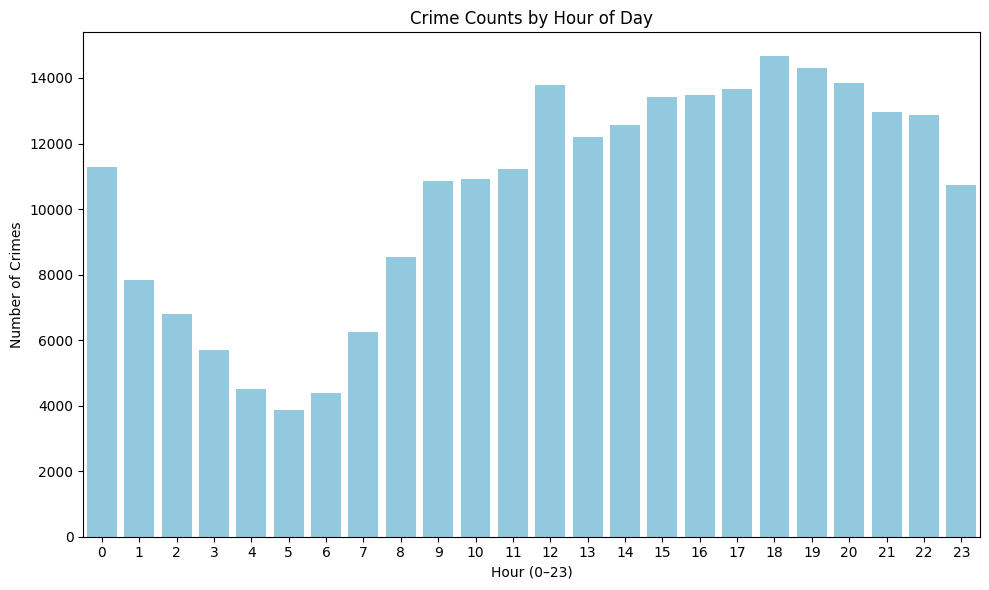

In [8]:
#bin Time of Day 
hour_counts = df_timedate['Hour'].value_counts().sort_index()

plt.figure(figsize=(10,6))
sns.barplot(x=hour_counts.index, y=hour_counts.values, color='skyblue')
plt.title('Crime Counts by Hour of Day')
plt.xlabel('Hour (0–23)')
plt.ylabel('Number of Crimes')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

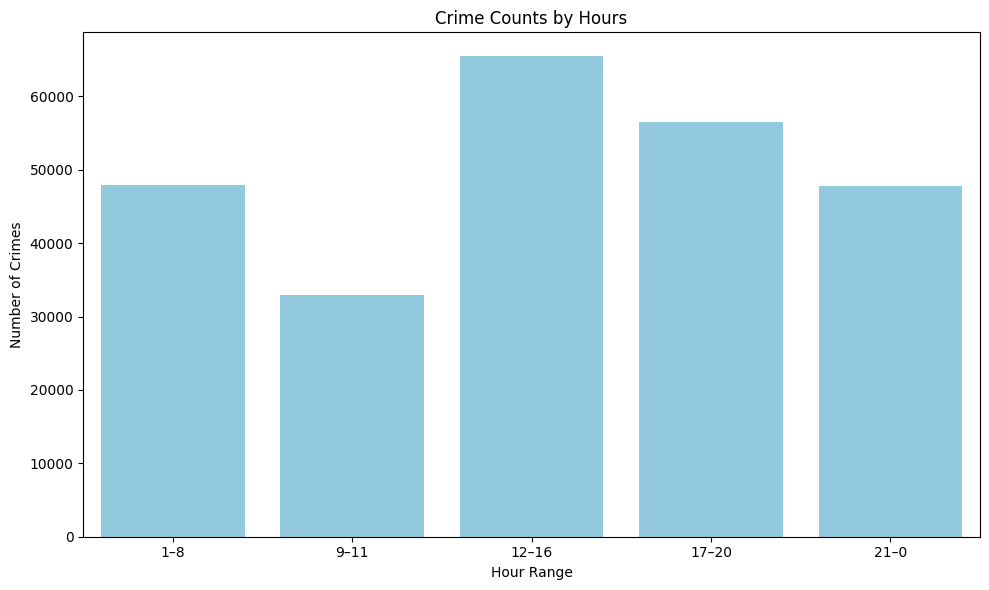

In [ ]:
df_timedate['HourAdjusted'] = df_timedate['Hour'].replace(0, 24)

bins = [0, 8, 11, 16, 20, 24]
labels = ['1-8', '9-11', '12-16', '17-20', '21-0']

df_timedate['HourBinned'] = pd.cut(df_timedate['HourAdjusted'], bins=bins, labels=labels, right=True, include_lowest=False)

hourblock_counts = df_timedate['HourBinned'].value_counts().reindex(labels)

plt.figure(figsize=(10,6))
sns.barplot(x=hourblock_counts.index, y=hourblock_counts.values, color='skyblue')
plt.title('Crime Counts by Hours')
plt.xlabel('Hour Range')
plt.ylabel('Number of Crimes')
plt.tight_layout()
plt.show()

<h4>Weekday/Weekend</h4>

In [10]:
#bin Weekday/Weekend 
df_timedate['FullDate'] = '2016-' + df_timedate['Date']
df_timedate['FullDate'] = pd.to_datetime(df_timedate['FullDate'], format='%Y-%m-%d')
df_timedate['DayOfWeek'] = df_timedate['FullDate'].dt.dayofweek
df_timedate['DayBinned'] = df_timedate['DayOfWeek'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')
df_timedate.drop(columns=['FullDate', 'DayOfWeek'], inplace=True)
df_timedate.head()

,Date,Hour,Season,HourAdjusted,HourBinned,DayBinned
0,05-03,23,Spring,23,21–0,Weekday
1,05-03,21,Spring,21,21–0,Weekday
2,05-03,23,Spring,23,21–0,Weekday
3,05-03,22,Spring,22,21–0,Weekday
4,05-03,22,Spring,22,21–0,Weekday


In [11]:
df_timedate = df_timedate[['Season', 'HourBinned', 'DayBinned']]

df_dummies = pd.get_dummies(df_timedate, columns=['Season', 'HourBinned', 'DayBinned'], prefix_sep='=')

#df_timedate.head()
df_dummies.head()

,Season=Fall,Season=Spring,Season=Summer,Season=Winter,HourBinned=1–8,HourBinned=9–11,HourBinned=12–16,HourBinned=17–20,HourBinned=21–0,DayBinned=Weekday,DayBinned=Weekend
0,False,True,False,False,False,False,False,False,True,True,False
1,False,True,False,False,False,False,False,False,True,True,False
2,False,True,False,False,False,False,False,False,True,True,False
3,False,True,False,False,False,False,False,False,True,True,False
4,False,True,False,False,False,False,False,False,True,True,False


In [12]:
df_crime = pd.concat([df_crime, df_timedate[['Season', 'HourBinned', 'DayBinned']]], axis=1)
# df_crime = pd.concat([df_crime, df_dummies], axis=1)
df_crime.head()

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Latitude,Longitude,Location,Season,HourBinned,DayBinned
0,10508693,2016-05-03 23:40:00,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,1022,10,24,29,41.864073,-87.706819,"(41.864073157, -87.706818608)",Spring,21–0,Weekday
1,10508695,2016-05-03 21:40:00,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,313,3,20,42,41.782922,-87.604363,"(41.782921527, -87.60436317)",Spring,21–0,Weekday
2,10508697,2016-05-03 23:31:00,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,False,False,1524,15,37,25,41.894908,-87.758372,"(41.894908283, -87.758371958)",Spring,21–0,Weekday
3,10508698,2016-05-03 22:10:00,BATTERY,SIMPLE,SIDEWALK,False,False,1532,15,28,25,41.885687,-87.749516,"(41.885686845, -87.749515983)",Spring,21–0,Weekday
4,10508699,2016-05-03 22:00:00,THEFT,$500 AND UNDER,RESIDENCE,False,True,1523,15,28,25,41.886297,-87.761751,"(41.886297242, -87.761750709)",Spring,21–0,Weekday


In [13]:
df_crime['Location Description'].value_counts()

Location Description
STREET           59345
RESIDENCE        40786
APARTMENT        31786
SIDEWALK         22413
OTHER             9950
                 ...  
CTA "L" TRAIN        1
NURSING HOME         1
VESTIBULE            1
LAUNDRY ROOM         1
OFFICE               1
Name: count, Length: 127, dtype: int64

<h4>Private/Public</h4>

In [14]:
#bin Location Description (Private vs. Public) 
def locdes_bin(value):
        if value in ['OTHER', 'ABANDONED BUILDING', 'CONSTRUCTION SITE', 'VACANT LOT', 'VACANT LOT/LAND']:
            return 'OTHER'
        if value in ['APARTMENT', 'CHA APARTMENT', 'CHA PARKING LOT/GROUNDS', 'DRIVEWAY - RESIDENTIAL', 'HOUSE', 'NURSING HOME', 'PORCH', 'RESIDENCE', 'RESIDENCE PORCH/HALLWAY', 'RESIDENCE-GARAGE', 'RESIDENTIAL YARD (FRONT/BACK)', 'CHA HALLWAY/STAIRWELL/ELEVATOR', 'CHA PARKING LOT', 'DRIVEWAY', 'GARAGE', 'HALLWAY', 'LAUNDRY ROOM', 'ELEVATOR', 'VESTIBULE', 'YARD']:
            return 'PRIVATE - HOUSING'
        if value in ['CHURCH/SYNAGOGUE/PLACE OF WORSHIP', 'CEMETARY']:
            return 'PRIVATE - PLACE OF WORSHIP'
        if value in ['AUTO', 'OTHER COMMERCIAL TRANSPORTATION', 'TAXICAB', 'BOAT/WATERCRAFT', 'VEHICLE - DELIVERY TRUCK', 'VEHICLE - OTHER RIDE SERVICE', 'VEHICLE NON-COMMERCIAL', 'VEHICLE-COMMERCIAL']:
            return 'PRIVATE - TRANSPORTATION'
        if value in ['FEDERAL BUILDING', 'FIRE STATION', 'GOVERNMENT BUILDING/PROPERTY', 'JAIL/LOCK-UP FACILITY', 'LIBRARY', 'POLICE FACILITY/VEH PARKING LOT']:
            return 'PUBLIC - GOVERNMENT'
        if value in ['BRIDGE', 'GANGWAY', 'HIGHWAY/EXPRESSWAY', 'ALLEY', 'SIDEWALK', 'STREET']:
            return 'PUBLIC - INFRASTRUCTURE'
        if value in ['FOREST PRESERVE', 'PARK PROPERTY', 'LAKEFRONT/WATERFRONT/RIVERBANK']:
            return 'PUBLIC - RECREATION'
        if value in ['COLLEGE/UNIVERSITY GROUNDS', 'COLLEGE/UNIVERSITY RESIDENCE HALL', 'SCHOOL YARD', 'SCHOOL, PRIVATE, BUILDING', 'SCHOOL, PRIVATE, GROUNDS', 'SCHOOL, PUBLIC, BUILDING', 'SCHOOL, PUBLIC, GROUNDS']:
            return 'PUBLIC - SCHOOL'
        if value in ['AIRCRAFT', 'AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA', 'AIRPORT BUILDING NON-TERMINAL - SECURE AREA', 'AIRPORT EXTERIOR - NON-SECURE AREA', 'AIRPORT EXTERIOR - SECURE AREA', 'AIRPORT PARKING LOT', 'AIRPORT TERMINAL LOWER LEVEL - NON-SECURE AREA', 'AIRPORT TERMINAL LOWER LEVEL - SECURE AREA', 'AIRPORT TERMINAL MEZZANINE - NON-SECURE AREA', 'AIRPORT TERMINAL UPPER LEVEL - NON-SECURE AREA', 'AIRPORT TERMINAL UPPER LEVEL - SECURE AREA', 'AIRPORT TRANSPORTATION SYSTEM (ATS)', 'AIRPORT VENDING ESTABLISHMENT', 'AIRPORT/AIRCRAFT', 'PARKING LOT', 'PARKING LOT/GARAGE(NON.RESID.)', 'CTA "L" TRAIN', 'CTA BUS', 'CTA BUS STOP', 'CTA GARAGE / OTHER PROPERTY', 'CTA PLATFORM', 'CTA STATION', 'CTA TRACKS - RIGHT OF WAY', 'CTA TRAIN', 'OTHER RAILROAD PROP / TRAIN DEPOT', 'RAILROAD PROPERTY']:
            return 'PUBLIC - TRANSPORTATION'
        else: return 'PRIVATE - BUSINESS'

df_crime['Location Description_Binned'] = df_crime['Location Description'].map(locdes_bin)

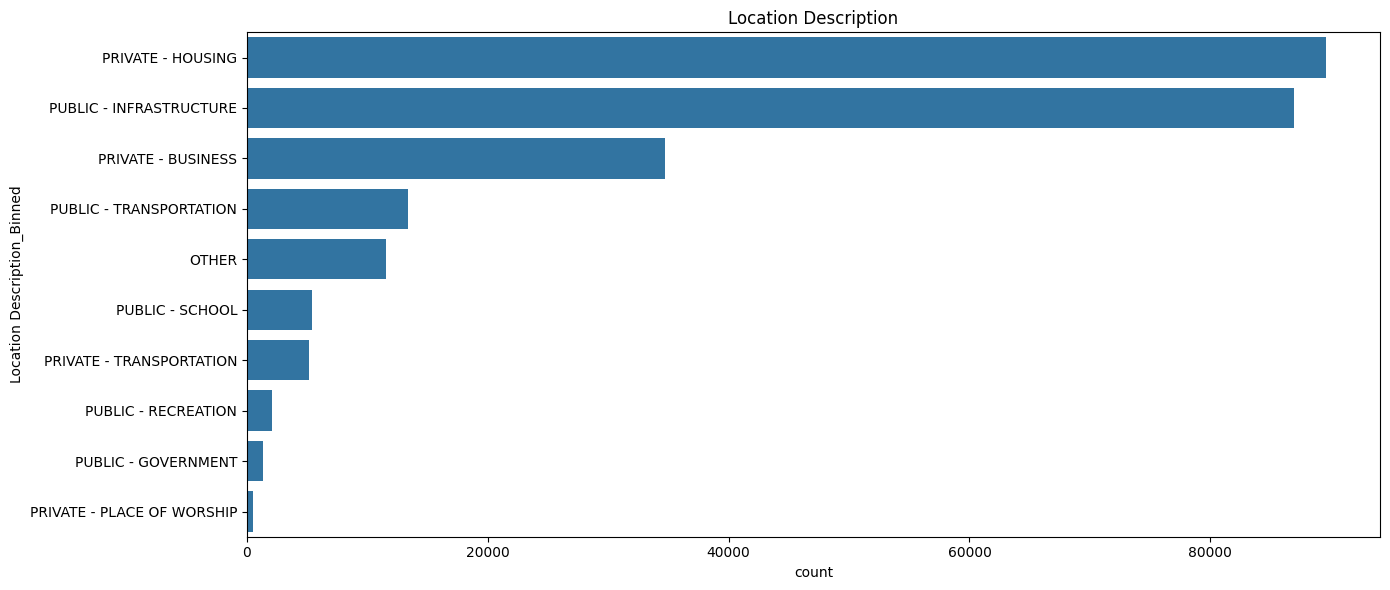

In [15]:
location_desc = df_crime['Location Description_Binned'].value_counts()

plt.figure(figsize=(14,6))
sns.countplot(data=df_crime, order=df_crime['Location Description_Binned'].value_counts().index, y='Location Description_Binned')
plt.title('Location Description')
plt.tight_layout()
plt.show()

Observations:
1.) The majority of crimes take place in public spaces tied to infrastructure and private housing and related facilities. 

<h4>Violent/Non-Violent</h4>

In [16]:
# Bin Primary Type/Description by Violent/Non-Violent 

crime_types = df_crime['Primary Type'].unique().tolist()
crime_types

['BATTERY',
 'PUBLIC PEACE VIOLATION',
 'THEFT',
 'WEAPONS VIOLATION',
 'ROBBERY',
 'MOTOR VEHICLE THEFT',
 'ASSAULT',
 'OTHER OFFENSE',
 'DECEPTIVE PRACTICE',
 'CRIMINAL DAMAGE',
 'CRIMINAL TRESPASS',
 'BURGLARY',
 'STALKING',
 'CRIM SEXUAL ASSAULT',
 'NARCOTICS',
 'SEX OFFENSE',
 'HOMICIDE',
 'OFFENSE INVOLVING CHILDREN',
 'INTERFERENCE WITH PUBLIC OFFICER',
 'PROSTITUTION',
 'KIDNAPPING',
 'GAMBLING',
 'INTIMIDATION',
 'ARSON',
 'LIQUOR LAW VIOLATION',
 'OBSCENITY',
 'NON-CRIMINAL',
 'PUBLIC INDECENCY',
 'HUMAN TRAFFICKING',
 'CONCEALED CARRY LICENSE VIOLATION',
 'NON - CRIMINAL',
 'NON-CRIMINAL (SUBJECT SPECIFIED)',
 'OTHER NARCOTIC VIOLATION']

In [17]:
# Regroup NON-CRIMINAL, NON - CRIMINAL, NON-CRIMINAL (SUBJECT SPECIFIED)
df_crime['Primary Type'] = df_crime['Primary Type'].str.strip().str.upper()

df_crime['Primary Type'] = df_crime['Primary Type'].replace({
    'NON - CRIMINAL': 'NON-CRIMINAL',
    'NON-CRIMINAL (SUBJECT SPECIFIED)': 'NON-CRIMINAL'
})

df_crime['Primary Type'].unique().tolist()

['BATTERY',
 'PUBLIC PEACE VIOLATION',
 'THEFT',
 'WEAPONS VIOLATION',
 'ROBBERY',
 'MOTOR VEHICLE THEFT',
 'ASSAULT',
 'OTHER OFFENSE',
 'DECEPTIVE PRACTICE',
 'CRIMINAL DAMAGE',
 'CRIMINAL TRESPASS',
 'BURGLARY',
 'STALKING',
 'CRIM SEXUAL ASSAULT',
 'NARCOTICS',
 'SEX OFFENSE',
 'HOMICIDE',
 'OFFENSE INVOLVING CHILDREN',
 'INTERFERENCE WITH PUBLIC OFFICER',
 'PROSTITUTION',
 'KIDNAPPING',
 'GAMBLING',
 'INTIMIDATION',
 'ARSON',
 'LIQUOR LAW VIOLATION',
 'OBSCENITY',
 'NON-CRIMINAL',
 'PUBLIC INDECENCY',
 'HUMAN TRAFFICKING',
 'CONCEALED CARRY LICENSE VIOLATION',
 'OTHER NARCOTIC VIOLATION']

In [18]:
#bin Primary Type/Description by Violent/Non-Violent 
violent_types = [
    'BATTERY',
    'ASSUALT',
    'ROBBERY',
    'CRIM SEX ASSUALT',
    'SEX OFFENSE',
    'HOMICIDE',
    'KIDNAPPING',
    'STALKING',
    'OFFENSE INVOLING CHILDREN',
    'INTIMIDATION',
    'HUMAN TRAFFICKING'
]

df_crime['Violent_Crime'] = df_crime['Primary Type'].apply(lambda x: 'Violent' if x in violent_types else 'Non-Violent')

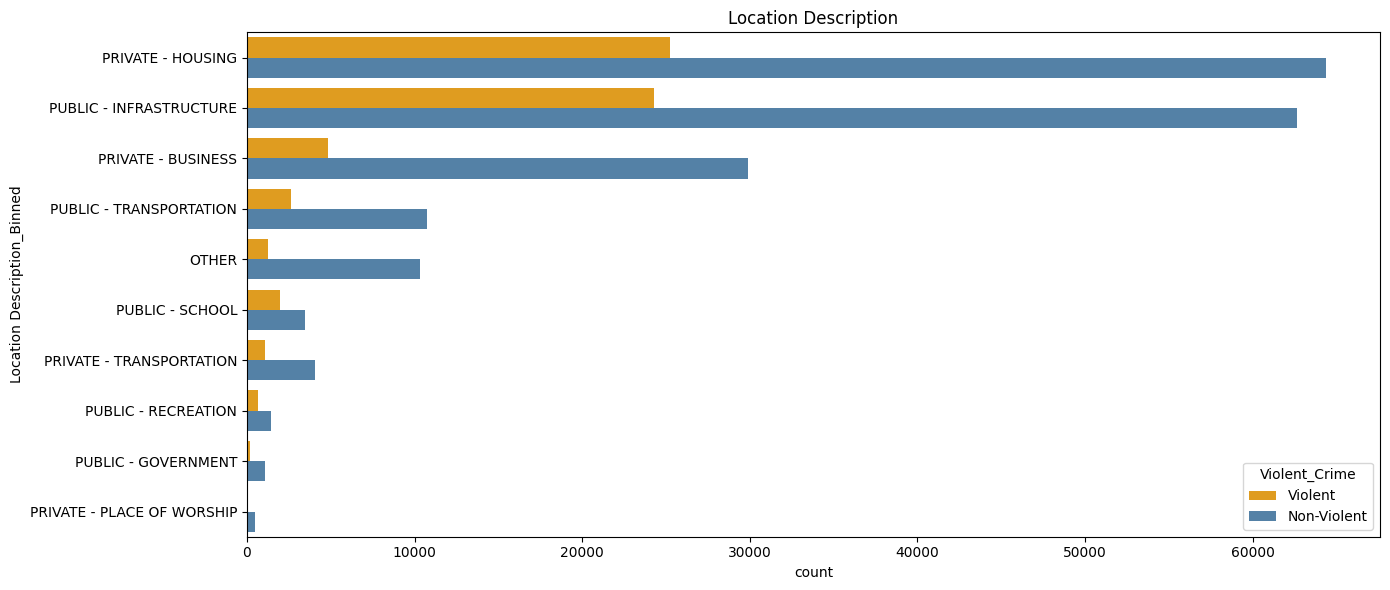

In [19]:
location_desc = df_crime['Location Description_Binned'].value_counts()

plt.figure(figsize=(14,6))
sns.countplot(data=df_crime, order=df_crime['Location Description_Binned'].value_counts().index, y='Location Description_Binned', hue='Violent_Crime',
             palette={'Violent' : 'orange', 'Non-Violent':'steelblue'})
plt.title('Location Description')
plt.tight_layout()
plt.show()

Observations: 1.) School grounds (public - school) has the highest proportion of violent crime. 2.) Private housing and public infrastructure not only represent the majority of crime committed, they also have some of the largest proportion of violent to non-violent crime.

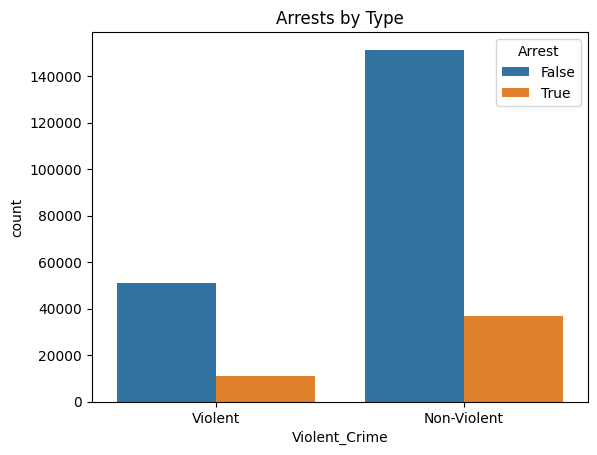

In [20]:
df_crime.groupby('Violent_Crime')['Arrest'].mean()
sns.countplot(data=df_crime, x='Violent_Crime', hue='Arrest')
plt.title('Arrests by Type')
plt.show()

##### Arrests by Type Observations:
* Most crimes do not result in arrests
* Non-violent crimes account for the majority of arrests due to their frequency
* Violent crimes show the highest arrest rate

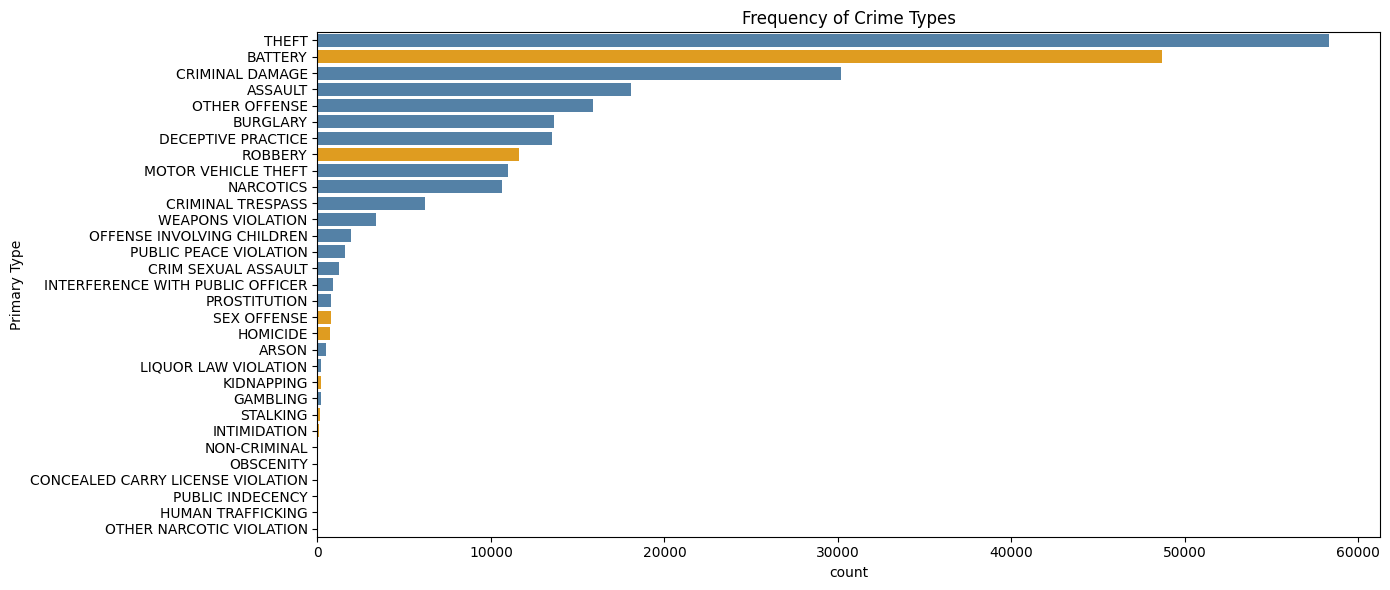

In [21]:
crime_count = df_crime['Primary Type'].value_counts()
color = ['orange' if crime in violent_types else 'steelblue' for crime in crime_count.index]

plt.figure(figsize=(14,6))
sns.countplot(data=df_crime, order=df_crime['Primary Type'].value_counts().index, y='Primary Type', palette=color)
plt.title('Frequency of Crime Types')
plt.tight_layout()
plt.show()

##### Frequency of Crime Types Observations:
* Theft is the most frequent crime in the dataset
* Battery is the most common violent crime in the dataset (orange highlight)

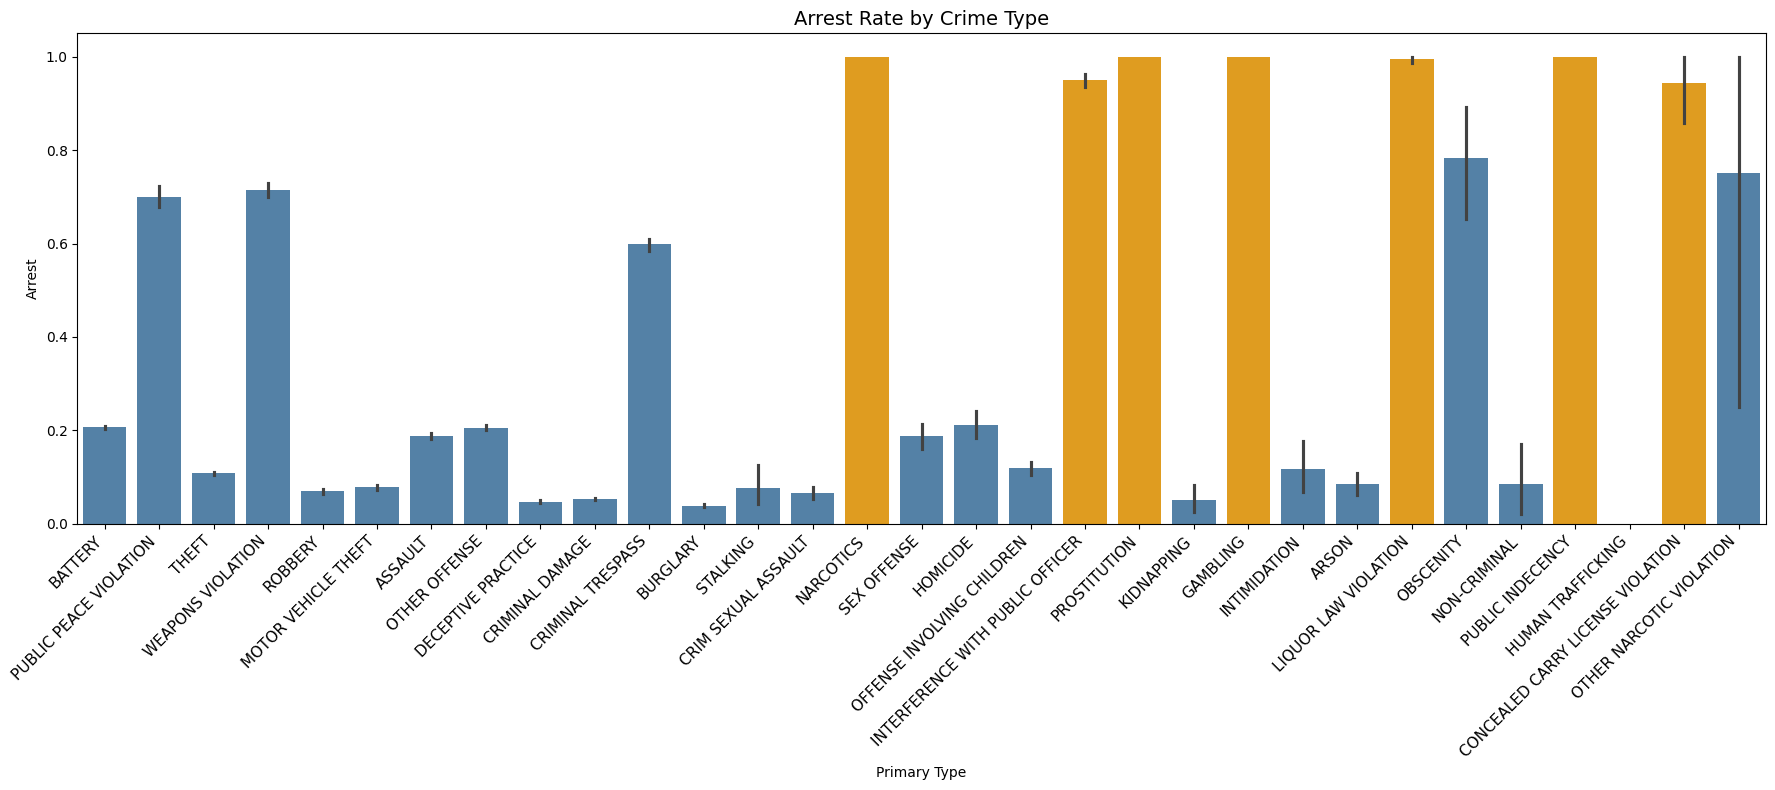

In [22]:
crime_type = df_crime['Primary Type'].unique()
arrest_mean = df_crime.groupby('Primary Type')['Arrest'].mean()
color = ['orange' if arrest_mean[crime] >=.9 else 'steelblue' for crime in crime_type]

plt.figure(figsize=(18,8))
sns.barplot(data=df_crime, x='Primary Type', y='Arrest', estimator=np.mean, palette=color)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.title('Arrest Rate by Crime Type', fontsize=14)
plt.tight_layout()
plt.show()

##### Arrest Rate by Crime Type Observations:
* Narcotics, intereference with public officer, prositution, gambling, 
    liquor law violation, public idencencyand concealed carry license violation all have arrest rates greater than or equal to 90%
* The black vertical lines represent variation in arrest outcomes, the longer the line the higher the inconsistency
* Other narcotic violation has the highest variation and needs to be considered in the feature engineering phase

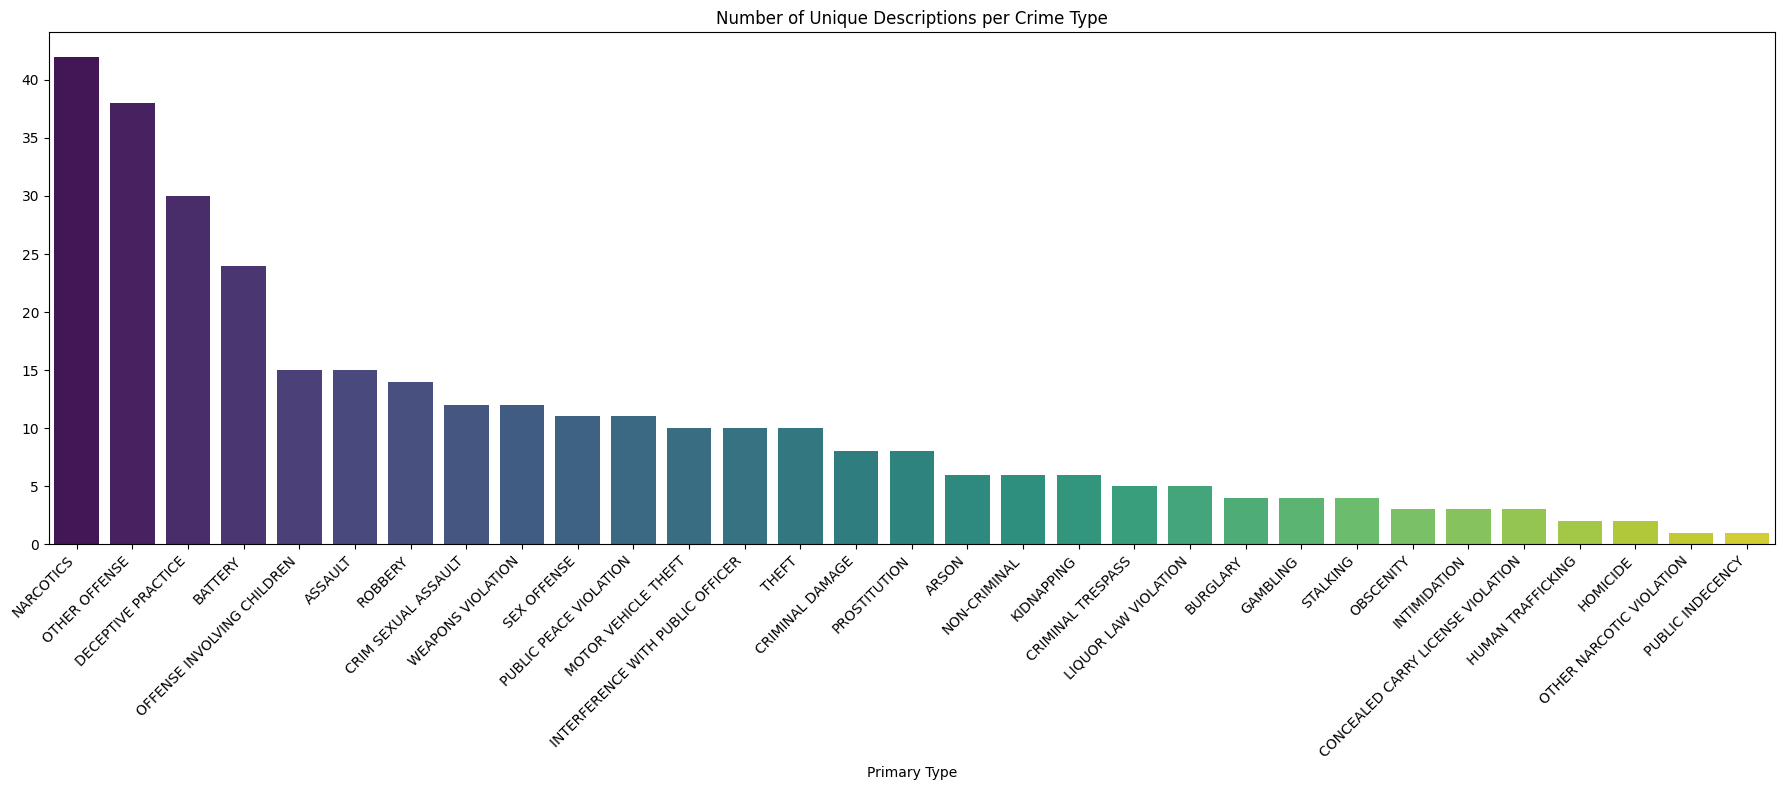

In [23]:
description_count = df_crime.groupby('Primary Type')['Description'].nunique().sort_values(ascending=False)

plt.figure(figsize=(18,8))
sns.barplot(x=description_count.index, y=description_count.values, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Number of Unique Descriptions per Crime Type')
plt.tight_layout()
plt.show()

##### Number of Unique Descriptions per Crime Type Observations:
* This graph illustrates which crimes have the most unique descriptions
* Low-cardinality categories are ideal candidates for modeling (Public Indecency, Other Narcotic Violation, Homicide)
* High-cardinality can dilute model accuracy, indicating need for feature engineering (Narcotics, Other Offense, Deceptive Practice)

<h4>Primary Type</h4>

In [24]:
df_crime["Primary Type"].value_counts()

Primary Type
THEFT                                58328
BATTERY                              48686
CRIMINAL DAMAGE                      30189
ASSAULT                              18080
OTHER OFFENSE                        15910
BURGLARY                             13612
DECEPTIVE PRACTICE                   13511
ROBBERY                              11611
MOTOR VEHICLE THEFT                  11005
NARCOTICS                            10664
CRIMINAL TRESPASS                     6209
WEAPONS VIOLATION                     3398
OFFENSE INVOLVING CHILDREN            1953
PUBLIC PEACE VIOLATION                1579
CRIM SEXUAL ASSAULT                   1267
INTERFERENCE WITH PUBLIC OFFICER       926
PROSTITUTION                           780
SEX OFFENSE                            770
HOMICIDE                               749
ARSON                                  504
LIQUOR LAW VIOLATION                   210
KIDNAPPING                             193
GAMBLING                               18

In [25]:
#bin Primary Type (new column)
def pt_bin(value):
    if value in ["CRIMINAL DAMAGE","ARSON"]:
        return "CRIMINAL DAMAGE/ARSON"
    if value in ["THEFT","BURGLARY","ROBBERY","MOTOR VEHICLE THEFT"]:
        return "THEFT/BURGLARY/ROBBERY"
    if value in ["BATTERY","ASSAULT"]:
        return "ASSAULT/BATTERY"
    if value in ["OTHER OFFENSE","LIQUOR LAW VIOLATION","KIDNAPPING","GAMBLING","NON-CRIMINAL","HUMAN TRAFFICKING","NON - CRIMINAL","NON-CRIMINAL (SUBJECT SPECIFIED)"]:
        return "OTHER/NON-CRIMINAL"
    if value in ["NARCOTICS","OTHER NARCOTIC VIOLATION"]:
        return "NARCOTICS"
    if value in ["WEAPONS VIOLATION","CONCEALED CARRY LICENSE VIOLATION"]:
        return "WEAPONS VIOLATION/CCL VIOLATION"
    if value in ["PUBLIC PEACE VIOLATION","STALKING","INTIMIDATION","OBSCENITY","PUBLIC INDECENCY"]:
        return "PUBLIC PEACE/INDECENCY VIOLATION"
    if value in ["CRIM SEXUAL ASSAULT","PROSTITUTION","SEX OFFENSE"]:
        return "SEX OFFENSE/ASSAULT"
    else:
        return value

df_crime["Primary Type (Binned)"] = df_crime["Primary Type"].map(pt_bin)

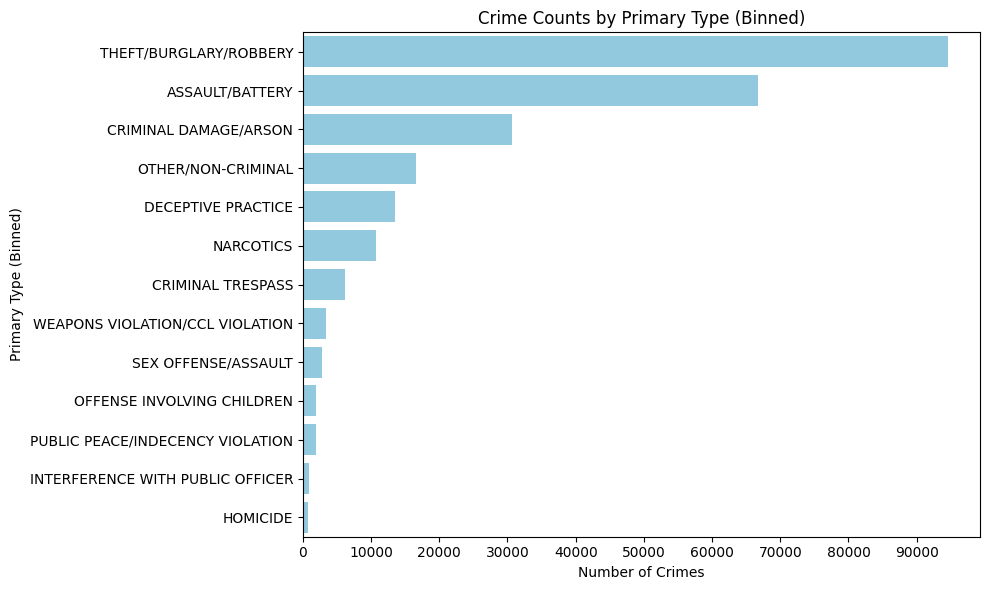

In [26]:
pt_counts = df_crime["Primary Type (Binned)"].value_counts()

plt.figure(figsize=(10,6))
sns.barplot(x=pt_counts.values, y=pt_counts.index, color='skyblue')
plt.title('Crime Counts by Primary Type (Binned)')
plt.ylabel('Primary Type (Binned)')
plt.xlabel('Number of Crimes')
plt.xticks(np.arange(0, 100000, 10000))
plt.tight_layout()
plt.show()

In [27]:
df_crime.head()

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Latitude,Longitude,Location,Season,HourBinned,DayBinned,Location Description_Binned,Violent_Crime,Primary Type (Binned)
0,10508693,2016-05-03 23:40:00,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,1022,10,24,29,41.864073,-87.706819,"(41.864073157, -87.706818608)",Spring,21–0,Weekday,PRIVATE - HOUSING,Violent,ASSAULT/BATTERY
1,10508695,2016-05-03 21:40:00,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,313,3,20,42,41.782922,-87.604363,"(41.782921527, -87.60436317)",Spring,21–0,Weekday,PRIVATE - HOUSING,Violent,ASSAULT/BATTERY
2,10508697,2016-05-03 23:31:00,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,False,False,1524,15,37,25,41.894908,-87.758372,"(41.894908283, -87.758371958)",Spring,21–0,Weekday,PUBLIC - INFRASTRUCTURE,Non-Violent,PUBLIC PEACE/INDECENCY VIOLATION
3,10508698,2016-05-03 22:10:00,BATTERY,SIMPLE,SIDEWALK,False,False,1532,15,28,25,41.885687,-87.749516,"(41.885686845, -87.749515983)",Spring,21–0,Weekday,PUBLIC - INFRASTRUCTURE,Violent,ASSAULT/BATTERY
4,10508699,2016-05-03 22:00:00,THEFT,$500 AND UNDER,RESIDENCE,False,True,1523,15,28,25,41.886297,-87.761751,"(41.886297242, -87.761750709)",Spring,21–0,Weekday,PRIVATE - HOUSING,Non-Violent,THEFT/BURGLARY/ROBBERY


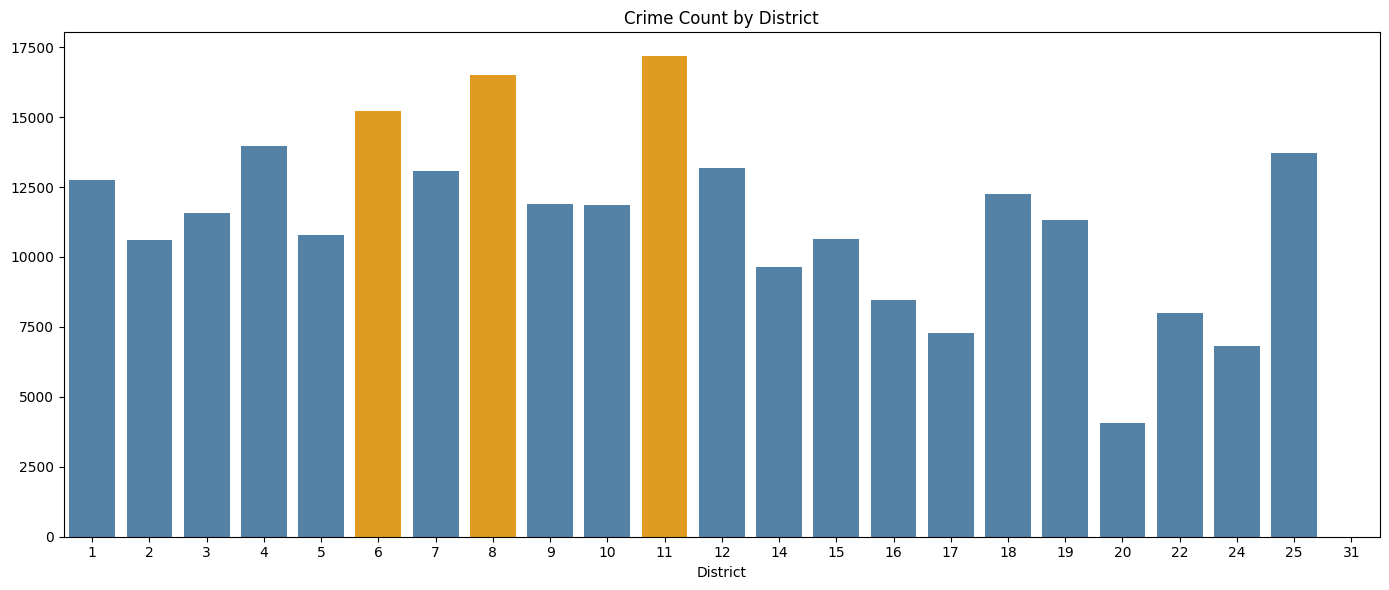

In [28]:
district_count = df_crime['District'].value_counts().sort_index()
color = ['orange' if count >= 15000 else 'steelblue' for count in district_count.values]

plt.figure(figsize=(14,6))
sns.barplot(x=district_count.index, y=district_count.values, palette=color)
plt.title('Crime Count by District')
plt.tight_layout()
plt.show()

##### Crime Count by District Observations:
* Districts 6,8,11 each have an individaul count of greater than or equal to 15000 crimes
* Distirct 20 has the lowest volume of crime

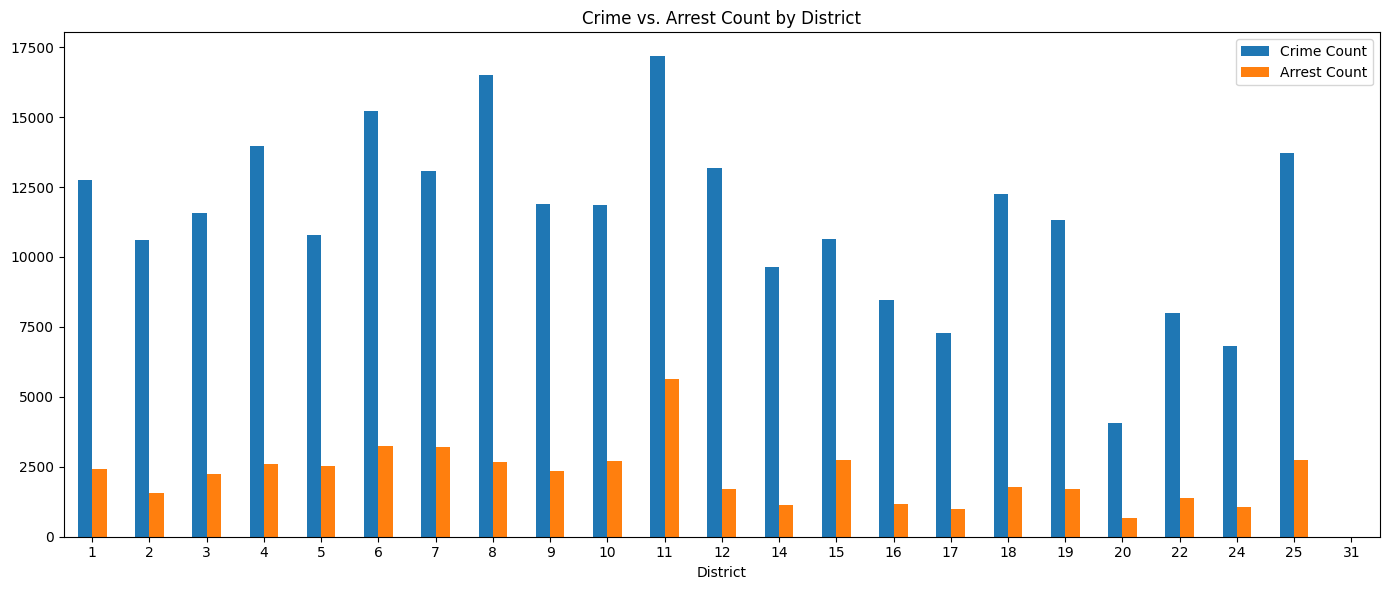

In [29]:
# district_df created as a temporary dataframe for visualizations

crime_count = df_crime['District'].value_counts().sort_index()
arrest_count = df_crime[df_crime['Arrest'] == True]['District'].value_counts().sort_index()

district_df = pd.DataFrame({
    'Crime Count': crime_count,
    'Arrest Count': arrest_count
})

district_df.plot(kind='bar', figsize=(14,6))
plt.title('Crime vs. Arrest Count by District')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

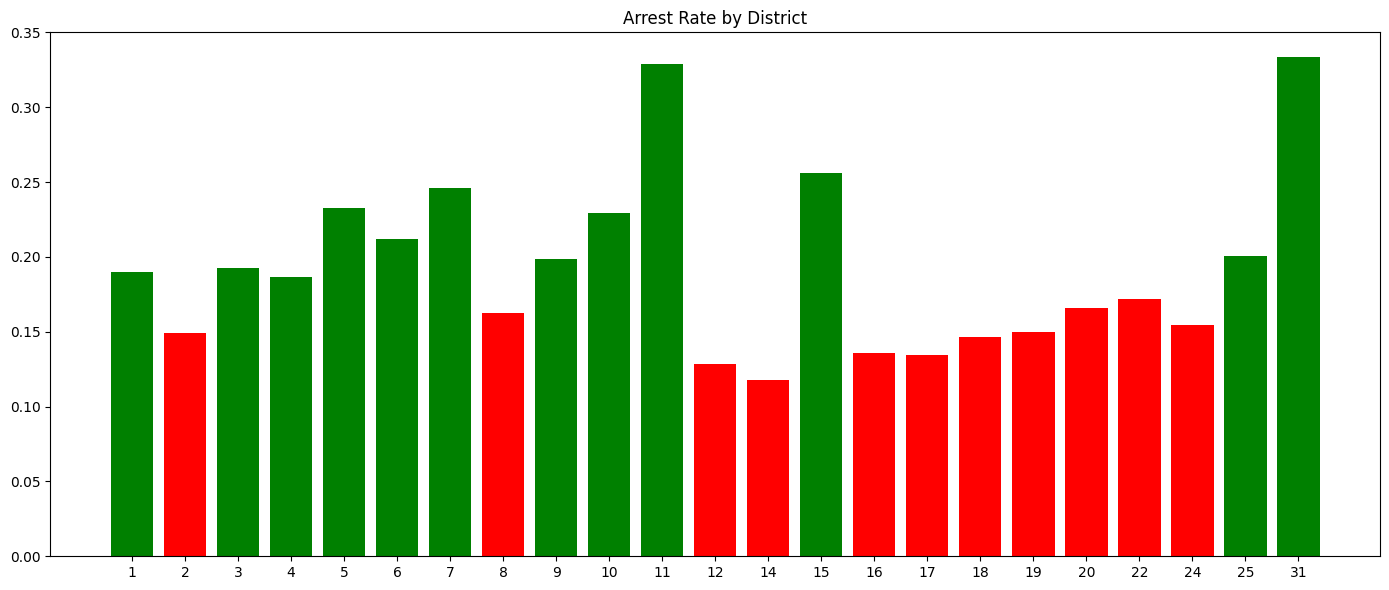

In [30]:
# district_df used again

district_df['Arrest Rate'] = district_df['Arrest Count'] / district_df['Crime Count']
median_thresh = district_df['Arrest Rate'].median()
district_df['Safe'] = district_df['Arrest Rate'] >= median_thresh
color = ['green' if is_safe else 'red' for is_safe in district_df['Safe']]

plt.figure(figsize=(14,6))
plt.bar(district_df.index.astype(str), height=district_df['Arrest Rate'], color=color)
plt.title('Arrest Rate by District')
plt.tight_layout()
plt.show()

##### Arrest Count by District, Crime vs. Arrest Count by District, Arrest Rate by District Observations
##### Arrest Rate by District: Green indicates "safe" district based on median measure of arrest_count / crime_count
* District 11 has the highest arrest and crime count (more law enforcement resources?)
    * District 11 should be treated as an oultier in the modeling phase (potential scaling)
* High crime does not always mean high arrest rates (District 8)(create a measure for arrest efficiency?)
* District 20 has the lowest crime and arrest (poor percentage based on median)
#### -- Is there a significant structural imbalance between districts that could impact the accuracy of the model? --

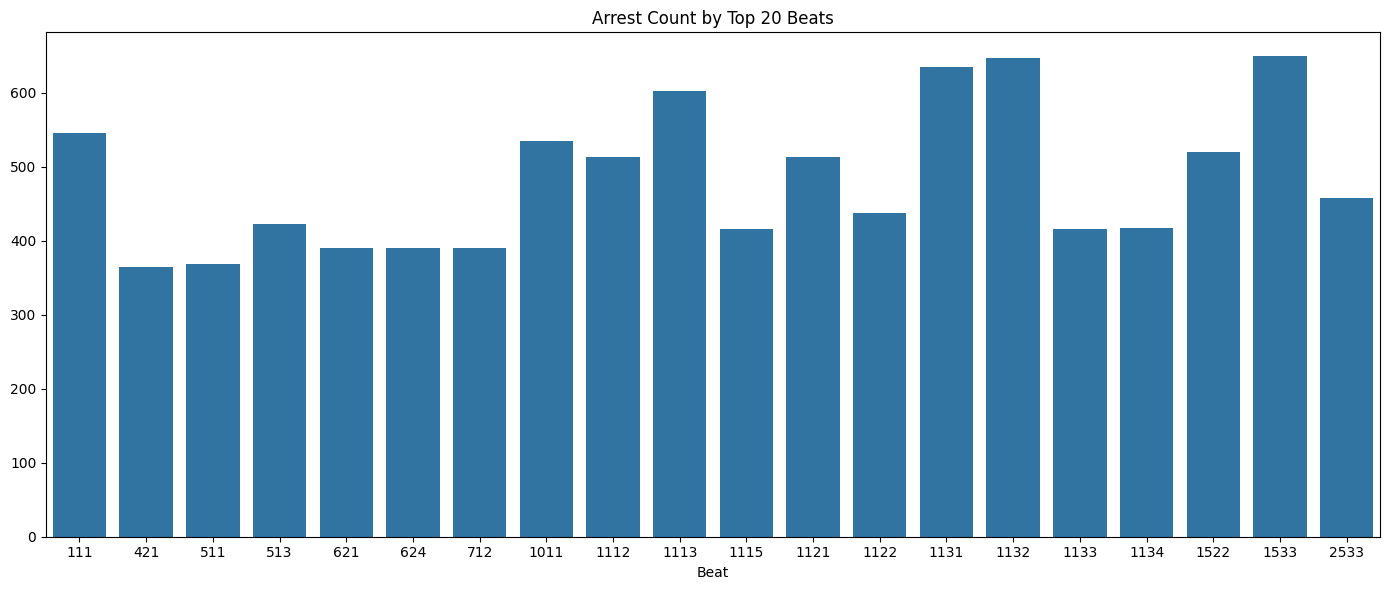

In [31]:
beat_arrests = df_crime[df_crime['Arrest'] == True]['Beat'].value_counts().nlargest(20)

plt.figure(figsize=(14,6))
sns.barplot(x=beat_arrests.index, y=beat_arrests.values)
plt.title('Arrest Count by Top 20 Beats')
plt.tight_layout()
plt.show()

In [32]:
df_crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250732 entries, 0 to 250731
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   ID                           250732 non-null  int64         
 1   Date                         250732 non-null  datetime64[ns]
 2   Primary Type                 250732 non-null  object        
 3   Description                  250732 non-null  object        
 4   Location Description         250732 non-null  object        
 5   Arrest                       250732 non-null  bool          
 6   Domestic                     250732 non-null  bool          
 7   Beat                         250732 non-null  int64         
 8   District                     250732 non-null  int64         
 9   Ward                         250732 non-null  int64         
 10  Community Area               250732 non-null  int64         
 11  Latitude                  

<h3>Defining Features</h3>

##### We dropped columns that lacked predictive value or were transformed through feature engineering (X)
##### Numerical features and dropped columns are reintroduced later for extended experimentation
##### Our code structure establishes flexibility, making future modifications straightforward

In [33]:
X = df_crime.drop(columns=['ID', 'Date', 'Arrest', 'Location'])
y = df_crime['Arrest']

In [34]:
numerical_features = ['Beat', 'District', 'Ward', 'Community Area', 'Latitude', 'Longitude']
categorical_features = ['Primary Type', 'Description', 'Domestic', 'Season', 'HourBinned', 'DayBinned',
                        'Location Description_Binned', 'Violent_Crime', 'Primary Type (Binned)']

<h3>Training vs. Testing</h3>

##### We were able to use 25% of the data set as a test set due to the high volume of data contained within the dataset. 
##### A random state of 42 is specified to ensure the test and training data sets remain the same across all models and iterations to allow for more uniform comparison. 

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42, stratify=y)

<h3>Preprocessing Pipeline</h3>

##### Pipline created to handle missing values, apply median imputation, and scale numerical features
##### Ensures data preservation and proper conversion into machine readable format
##### Combining all steps into a column transformer creates a clean, reusable preprocessing step

In [36]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'median')), 
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('encoder', OneHotEncoder(handle_unknown='ignore')) 
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

<h3>Model Pipeline Without Parameters</h3>

##### Inital model pipeline ran without parameters to establish baseline performance
##### Evaluation highlights which model naturally fits the data before tuning
##### Mix between ensemble and simple models for comparison ("let the data do the talking")

In [37]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=500),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

<h3>Model Evaluation Without Parameters</h3>

In [38]:
for name, model in models.items():
    print(f"\n{name} Model Evaluation in Progress")

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f"\n {name} ROC AUC Score: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


Random Forest Model Evaluation in Progress

 Random Forest ROC AUC Score: 0.8775
Confusion Matrix:
[[48772  1856]
 [ 5268  6787]]
Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.96      0.93     50628
        True       0.79      0.56      0.66     12055

    accuracy                           0.89     62683
   macro avg       0.84      0.76      0.79     62683
weighted avg       0.88      0.89      0.88     62683


Gradient Boosting Model Evaluation in Progress

 Gradient Boosting ROC AUC Score: 0.8742
Confusion Matrix:
[[49676   952]
 [ 5880  6175]]
Classification Report:
              precision    recall  f1-score   support

       False       0.89      0.98      0.94     50628
        True       0.87      0.51      0.64     12055

    accuracy                           0.89     62683
   macro avg       0.88      0.75      0.79     62683
weighted avg       0.89      0.89      0.88     62683


Logistic Regression Model Eva

<h3>Model Parameter Distributions</h3>

##### Paramter grid built for hyperparameter tuning purposes
##### Structure ecourages experimentation with easy adjustments
##### Best model is captured for final evaluation

In [39]:
models = {
    'Random Forest': (
        RandomForestClassifier(random_state=42),  
        {
            'classifier__n_estimators': [50, 100, 200], 
            'classifier__max_depth': [2, 3, 4, 10,], 
            'classifier__min_samples_split': [2,5], 
        }
    ),
    'Gradient Boosting': (
        GradientBoostingClassifier(random_state=42),
        {
            'classifier__n_estimators': [50, 100, 200], 
            'classifier__max_depth': [2, 3, 5], 
            'classifier__min_samples_split': [2,5], 
            'classifier__learning_rate': [.05, .1]  
        }
    ),
    'Logistic Regression': (
        LogisticRegression(max_iter=500),
        {
            'classifier__C': [.1, 1, 5, 10], 
            'classifier__solver': ['liblinear', 'saga'] 
        }
    ),
    'Decision Tree': (
        DecisionTreeClassifier(random_state=42),
        {
            'classifier__max_depth': [2, 3, 5], 
            'classifier__min_samples_split': [2,5] 
        }
    )
}

<h3>Model Tuning</h3>

In [40]:
for name, (model, param_dist) in models.items():
    print(f"\n{name} Tuning in Progress")

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_dist,
        n_iter=15, 
        scoring='roc_auc',
        cv=3, 
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    search.fit(X_train, y_train)
    best_model = search.best_estimator_


Random Forest Tuning in Progress
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Gradient Boosting Tuning in Progress
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Logistic Regression Tuning in Progress
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Decision Tree Tuning in Progress
Fitting 3 folds for each of 6 candidates, totalling 18 fits


<h3>Best Model Evaluation</h3>

##### Applied custom probability threshold to improve recall
##### Overall the untuned models outperformed tuning efforts


In [44]:
print(f"\n {name} Most Optimal Parameters:")
print(search.best_params_)

# Extra tuning needed to fix true recall score
y_proba = best_model.predict_proba(X_test)[:, 1]
thresh = .3
y_pred_custom = (y_proba >= thresh).astype(int)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"\n {name} ROC AUC Score: {roc_auc:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_custom))
print("Classification Report:")
print(classification_report(y_test, y_pred_custom))


 Decision Tree Most Optimal Parameters:
{'classifier__min_samples_split': 5, 'classifier__max_depth': 5}

 Decision Tree ROC AUC Score: 0.7889
Confusion Matrix:
[[49232  1396]
 [ 6821  5234]]
Classification Report:
              precision    recall  f1-score   support

       False       0.88      0.97      0.92     50628
        True       0.79      0.43      0.56     12055

    accuracy                           0.87     62683
   macro avg       0.83      0.70      0.74     62683
weighted avg       0.86      0.87      0.85     62683

